# Empirical Orthogonal Function Analysis

EOF analysis provides a simple and efficient means of evaluating the dominant modes of variability contained in a dataset. It is done by moving to a new mathematical basis which relates to the covariance of the data, and then focusing the analysis effort on the basis vectors that describe the majority of the variance. It is <u>Principal Component Analysis</u> applied to spatio-temporal data.

This code calculates both spatial and temporal eigenvectors (also known as eigenfunctions or EOFs) that describe the variance of a spatio-temporal dataset (e.g. shoreline Negition data along  a beach). 

The aim is to describe the datasets variability across both space and time with new basis functions. These are purely mathematic functions (eigenfunctions) but can sometimes relate closely to physical processes. Also, there is some research suggesting a relationship between alongshore and cross-shore transport processes and the shape of the eigenfunctions;
- extrema in the spatial eigenfunctions relates to areas of maximum variability,
- nodal points in the spatial eigenfunctions relates to areas of stability (low variability),
- multiple nodal points in the spatial eigenfunction may indicate the importance of longshore processes,
- spatial eigenfunctions without nodes can describe shoreline response to cross-shore processes (i.e. the entire coast advances/retreats in phase).

A full Negitive/negative spatial eigenfunction implies that if erosion (or accretion) is occurring at one location, erosion (or accretion) is also occurring at every other location. Gradients in this eigenfunction can imply a different rate of erosion/accretion.

See per Miller & Dean (2006, 2007): Shoreline variability via EOF analysis - https://doi.org/10.1016/j.coastaleng.2006.08.013.
This method has been used since by Harley et al. (2011) - https://doi.org/10.1029/2011JF001989 - to show that cross-shore processes are an important mode of variability in beach rotation.

Other useful references (EOFs or Principal Component Analysis):
- http://stockage.univ-brest.fr/~herbette/Data-Analysis/data_analysis_eof.pdf
- https://towardsdatascience.com/the-mathematics-behind-principal-component-analysis-fff2d7f4b643
- https://www.cygres.com/OcnPageE/Glosry/OcnEof1E.html

## 1 - Import Python Modules

In [1]:
# import packages and modules
import numpy as np
import os
import pandas as pd # package for working with tabular data in DataFrames
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting package
import datetime
import seaborn as sns # for plotting DataFrames (tabular data)
import scipy.stats as sst # For pearson correlation coefficients (linear test of correlation)
# System check
import sys
print('Python version:', sys.version,
      '\nAnaconda environment:', sys.executable)

Python version: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)] 
Anaconda environment: c:\Users\s5245653\Anaconda3\envs\datasci\python.exe


In [2]:
# Create function for converting month to season
def Month2Season(df):
    season_dict = {1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
                   6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10:'Spring',
                   11: 'Spring', 12: 'Summer'}
    season_val_dict = {'Summer': 1.0, 'Autumn': 2.0, 'Winter': 3.0, 'Spring': 4.0}
    df['Season'] = df['Month'].apply(lambda x: season_dict[x])
    df['Season_Val'] = df['Season'].apply(lambda x: season_val_dict[x])
    return df

## 2 - User Inputs

In [3]:
# Set and Check Directory
dataDir = 'C:/Users/s5245653/OneDrive - Griffith University/Projects/NaturalShorelineVariability_Grassy/data/'
plotDir = 'Plots/All/EOFs/v2/'
os.chdir(dataDir)

# User inputs
resamplePeriod = '1MS' # see Pandas documentation for frequency choices for resampling (e.g. monthly - '1MS')
transectSpacing = 50 # metres
inputFile = dataDir + 'RSP_raw.csv'
idxCol = 'dates' # index column in csv data (needs to be datetime)
minVarianceOfInterest = 5 # percent
firstDate = datetime.datetime(1987, 9, 1, tzinfo=datetime.timezone.utc) # year, month, day
lastDate = datetime.datetime(2020, 12, 31, tzinfo=datetime.timezone.utc)

# Plots
# Plotting
mpl.rcParams.update(mpl.rcParamsDefault)
# Formatting
colour = "grey"
plt.rcParams["text.color"] = colour
plt.rcParams["axes.labelcolor"] = colour
plt.rcParams["xtick.color"] = colour
plt.rcParams["ytick.color"] = colour
plt.rcParams["font.size"] = "14"
plt.gcf().autofmt_xdate()
resolution = 450


figSize = (10,6) # figure size in inches
yTitle = 'EOF' 
xTitle = 'Alongshore Distance From West (m)'
labelLoc = 'upper left'

yRange = [-0.55, 0.55] # Spatial EOF
yRangeTemp = [-0.199, 0.199] # Temporal EOF
plotName = dataDir + plotDir + f'{yTitle}_RSP_1.jpg'

# Second Plot
colTitles = ['Spatial', 'Temporal (Monthly Average)']
labelLetters = [['a)', 'b)'], ['c)', 'd)'], ['e)', 'f)']]
plot2Name = dataDir + plotDir + f'{yTitle}_RSP_MthlyAve.jpg'

<Figure size 640x480 with 0 Axes>

## 3 - Load and Clean Data

In [107]:
# Load Raw Data
dfRaw = pd.read_csv(inputFile, index_col = idxCol)
dfRaw.index = pd.to_datetime(dfRaw.index)

# Create a dataset clean enough for analysis (remove nan values etc.)
df = dfRaw.copy(deep = True)
df = df.dropna() # EOF analysis doesn't work with NaN values
df = df.truncate(before = firstDate, after = lastDate)
df = df - df.mean()
df

,0,50,100,150,200,250,300,350,400,450,...,750,800,850,900,950,1000,1050,1100,1150,1200
dates,,,,,,,,,,,,,,,,,,,,,
1987-09-16 23:31:08+00:00,5.415935,7.893919,12.063996,7.456841,1.337332,0.015785,-0.104755,-3.186935,-7.865843,-7.655475,...,-0.434633,1.862876,3.090583,0.167585,-0.102031,2.794535,-3.171670,-10.171027,-14.881775,-9.088978
1987-09-23 23:37:29+00:00,6.512805,15.821075,25.832699,20.546557,24.775491,20.489861,16.279757,12.961100,15.552053,15.749956,...,12.783555,23.726172,23.163240,23.249794,25.237176,20.738856,23.991782,20.780839,15.607855,9.924841
1987-10-25 23:38:03+00:00,-5.080562,-1.378393,1.483429,6.818004,10.018608,11.703792,7.222030,7.837127,6.660041,3.304201,...,3.530535,9.621912,12.991148,4.677143,-0.394841,2.742729,5.199013,1.012548,6.740083,4.721961
1988-04-11 23:34:20+00:00,-1.506805,-1.538895,-0.963321,2.938425,2.709741,3.820792,7.515753,5.752369,4.295033,4.821389,...,6.196170,8.060448,5.589380,8.590055,2.397910,-0.232725,2.883836,5.928518,4.320649,-1.851917
1988-06-21 23:41:02+00:00,14.571271,15.066898,30.994774,31.318380,28.197305,27.695414,23.096225,22.242995,23.772272,19.815200,...,6.751374,13.813577,18.377048,10.420453,9.755737,4.954416,7.262469,12.101879,11.231726,7.561111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-08 00:18:13+00:00,-12.473385,-9.904231,-5.992875,-10.562302,-6.215355,-2.954754,-3.507513,-1.648658,0.301328,-3.095350,...,2.282969,3.432681,3.327814,1.703284,1.702967,-0.992673,-1.799386,-2.533602,-6.390502,1.470440
2020-11-23 00:18:09+00:00,-13.677264,-13.106170,-14.984484,-13.413183,-9.251061,-8.764695,-5.997567,-3.246575,-4.409876,-2.521617,...,-17.094468,-9.701343,-5.127449,-7.656041,-7.103089,-9.527846,-10.668478,-9.785131,-8.287236,-8.683614
2020-11-26 00:28:05+00:00,-18.769210,-13.720808,-10.654297,-10.052446,-8.543321,-6.208840,-4.841390,-2.139468,-0.995196,0.758953,...,4.903273,1.008637,3.307150,-0.224679,0.807743,-1.932316,2.758963,-2.350460,-1.990763,-5.131697


C:\Users\s5245653\AppData\Local\Temp\ipykernel_19272\3729350494.py:3: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  dfPlot = dfRaw.truncate(before = '1996-12-01', after = '2008-01-01').resample('3MS').mean()


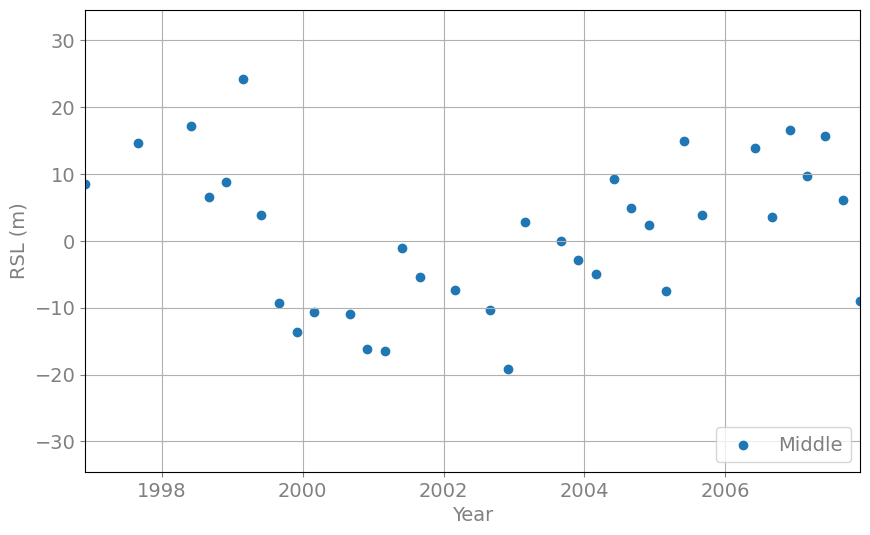

In [74]:
# Create dataframe for plotting
dfPlot = dfRaw.truncate(before = firstDate, after = lastDate).resample('3MS').mean()
dfPlot = dfRaw.truncate(before = '1996-12-01', after = '2008-01-01').resample('3MS').mean()
# Plot
fig, ax = plt.subplots(figsize = figSize)
#ax.plot(dfPlot["0"], label = "SW end")
ax.scatter(dfPlot.index, dfPlot["600"], label = "Middle")
#ax.plot(dfPlot["1200"], label = "E end")
# Format plot
ax.grid()
ax.set_xlim(dfPlot.index[0], dfPlot.index[-1])
ax.legend(loc = "lower right")
ax.set_ylabel("RSL (m)")
ax.set_xlabel("Year")
ax.set_ylim(-1 * np.max(np.abs(dfPlot["0"])), np.max(np.abs(dfPlot["0"])))
plt.show()


## 4 - Compute Eigenfunctions

In [108]:
# Try with resampling
df = dfRaw.copy(deep = True)
# df = dfRaw.truncate(before = '2015-01-31')
df = df.resample('1MS').mean()
df = df.dropna()
df

,0,50,100,150,200,250,300,350,400,450,...,750,800,850,900,950,1000,1050,1100,1150,1200
dates,,,,,,,,,,,,,,,,,,,,,
1987-09-01 00:00:00+00:00,7.966417,13.235891,20.240934,16.125877,15.152817,12.937370,10.385438,6.956044,6.933035,5.902898,...,7.341703,12.279896,13.483651,12.472957,13.718439,12.285933,10.256561,5.503109,0.444703,0.012312
1987-10-01 00:00:00+00:00,-3.078514,0.000000,2.776015,8.942182,12.115014,14.388340,9.519966,9.906088,9.749971,5.159858,...,4.697777,9.107283,13.347888,5.441411,0.756025,3.261966,5.045518,1.210751,6.821747,4.316342
1988-04-01 00:00:00+00:00,0.495242,-0.160502,0.329265,5.062602,4.806146,6.505339,9.813689,7.821330,7.384963,6.677046,...,7.363412,7.545820,5.946120,9.354323,3.548776,0.286512,2.730342,6.126721,4.402313,-2.257536
1988-06-01 00:00:00+00:00,16.573319,16.445291,32.287360,33.442557,30.293710,30.379961,25.394161,24.311956,26.862202,21.670857,...,7.918617,13.298949,18.733788,11.184721,10.906603,5.473654,7.108974,12.300082,11.313390,7.155492
1988-10-01 00:00:00+00:00,-8.223803,0.707300,-6.153669,2.070906,-4.887449,-3.566849,-4.682333,-2.962405,7.977137,-3.841543,...,-8.770224,-12.671801,-11.976645,-1.937516,3.182389,-0.547250,-2.780050,-2.767379,0.595101,-0.085976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 00:00:00+00:00,3.756266,-9.792985,5.062338,0.930565,5.840097,3.119905,3.644749,3.793464,3.166802,3.786811,...,0.470583,1.016459,2.831352,0.022800,-1.057768,-3.849035,-4.581209,-4.173424,-5.778049,-1.804925
2020-09-01 00:00:00+00:00,-27.671800,-25.745188,-12.313324,-9.734480,-9.984420,-18.516084,-14.490019,-21.058042,-19.959141,-10.659644,...,-4.228162,-6.550330,-6.033362,-1.639256,-4.536610,-12.037537,-11.966314,-12.832524,-8.730814,-9.131890
2020-10-01 00:00:00+00:00,-0.230633,-10.862183,-9.068924,-11.974880,-6.273190,-8.117855,-5.460668,-2.616350,-3.163346,-0.839469,...,-3.162879,-2.503193,-2.654954,-4.078218,-3.934211,-4.793720,-7.399180,-4.207491,-9.807678,-5.825623


In [109]:
# Create matrix of the data
y = df.to_numpy()
y_t = y.transpose()

# Create a spatial covariance-like matrix
temp = 1 / y.size
A = temp * np.matmul(y_t, y) # a measure of the spatial covariance
B = temp * np.matmul(y, y_t) # a measure of the temporal covariance

In [110]:
# Compute eigenvalues and eigenvectors from matrices
# Spatial
eigenValues, eigenVectors = np.linalg.eig(A)
# Temporal
eigenValuesB, c = np.linalg.eig(B)

# Returns eigenValues in order from largest to smallest, with eigenVectors returned as corresponding columns
# Spatial
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
e_x = eigenVectors[:,idx]
# Temporal
idx = eigenValuesB.argsort()[::-1]
eigenValuesB = eigenValuesB[idx] # first nx eigenvaluesB should equal eigenvalues from A
c_t = c[:,idx]

# Calculate percent of variance represented by the eigenfunctions
pOfVar = np.divide(100 * np.real(eigenValues), np.sum(np.real(eigenValues)))
k = sum(map(lambda x : x > minVarianceOfInterest, pOfVar)) # number of eigenfunctions (vectors) to plot
# Ensure at least 2 eigenfunctions are plotted
if k == 1:
    k = 2

k =3
    
# Weights
w = [np.sqrt(eigenValues[i]*y.size) for i in range(k)]

# Check eigenvalues match between spatial and temporal EOFs
np.round(np.real(eigenValuesB[0:min(y.shape)]), 4) == np.round(eigenValues, 4)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [111]:
# weights
print("Weights: ", w, "\nSum of weights: ", np.sum(w))
print("\nPercent of Variance:\n", pOfVar)

Weights:  [624.3622027408367, 329.4813611900591, 185.65681663746864] 
Sum of weights:  1139.5003805683643

Percent of Variance:
 [63.52293607 17.68964258  5.61667318  4.19762223  2.07885453  1.17674066
  0.87561094  0.64104136  0.58792805  0.50124569  0.43708699  0.37826179
  0.3284533   0.25702475  0.2420474   0.22071796  0.20838886  0.18655559
  0.17483052  0.16977809  0.13785965  0.10826085  0.09648543  0.09454416
  0.07140937]


In [112]:
for i in range(k):
    print(f'EOF{i+1}: {np.round(pOfVar[i], 1)}%')
    
print(f'Therefore, the first {k} EOFs describe {np.round(np.sum(pOfVar[0:k]),1)} of the total variance!')

EOF1: 63.5%
EOF2: 17.7%
EOF3: 5.6%
Therefore, the first 3 EOFs describe 86.8 of the total variance!


## 5 - Plot Results

In [113]:
c_t1 = np.real(c_t[:,0])
c_t2 = np.real(c_t[:,1])
c_t3 = np.real(c_t[:,2])

df['c_t1'] = c_t1
df['c_t2'] = c_t2
df['c_t3'] = c_t3

xtickMonths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#df.to_csv(dataDir + 'eofs.csv'

df.head()

,0,50,100,150,200,250,300,350,400,450,...,900,950,1000,1050,1100,1150,1200,c_t1,c_t2,c_t3
dates,,,,,,,,,,,,,,,,,,,,,
1987-09-01 00:00:00+00:00,7.966417,13.235891,20.240934,16.125877,15.152817,12.937370,10.385438,6.956044,6.933035,5.902898,...,12.472957,13.718439,12.285933,10.256561,5.503109,0.444703,0.012312,-0.078487,-0.029870,-0.032206
1987-10-01 00:00:00+00:00,-3.078514,0.000000,2.776015,8.942182,12.115014,14.388340,9.519966,9.906088,9.749971,5.159858,...,5.441411,0.756025,3.261966,5.045518,1.210751,6.821747,4.316342,-0.055137,0.011406,0.047009
1988-04-01 00:00:00+00:00,0.495242,-0.160502,0.329265,5.062602,4.806146,6.505339,9.813689,7.821330,7.384963,6.677046,...,9.354323,3.548776,0.286512,2.730342,6.126721,4.402313,-2.257536,-0.034565,0.006845,0.016094
1988-06-01 00:00:00+00:00,16.573319,16.445291,32.287360,33.442557,30.293710,30.379961,25.394161,24.311956,26.862202,21.670857,...,11.184721,10.906603,5.473654,7.108974,12.300082,11.313390,7.155492,-0.144990,-0.073082,-0.006396
1988-10-01 00:00:00+00:00,-8.223803,0.707300,-6.153669,2.070906,-4.887449,-3.566849,-4.682333,-2.962405,7.977137,-3.841543,...,-1.937516,3.182389,-0.547250,-2.780050,-2.767379,0.595101,-0.085976,0.030823,-0.000757,-0.015580


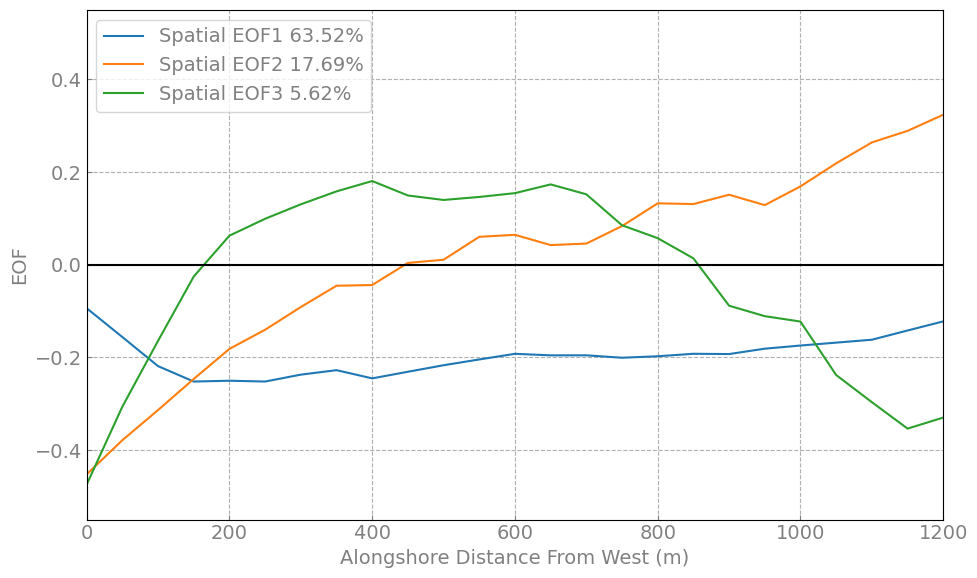

In [114]:
# Plot Spatial variability

# Plot Variables
numTransects = len(e_x)
xtickLabels = df.columns[::4]
xticks = np.arange(0, numTransects)[::4]

# Plotting
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)

for i in range(k):
    ax.plot(np.real(e_x[:,i]), label = f'Spatial EOF{i+1} {np.round(pOfVar[i], 2)}%')
ax.legend(loc = labelLoc)
ax.axhline(0, color = 'k')
ax.tick_params(direction="in")

plt.xticks(xticks, labels = xtickLabels)
plt.xlabel(xTitle)
plt.ylabel(yTitle)
plt.ylim(yRange)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(ls = '--')
plt.show()
#plt.savefig(plotName, dpi = resolution)

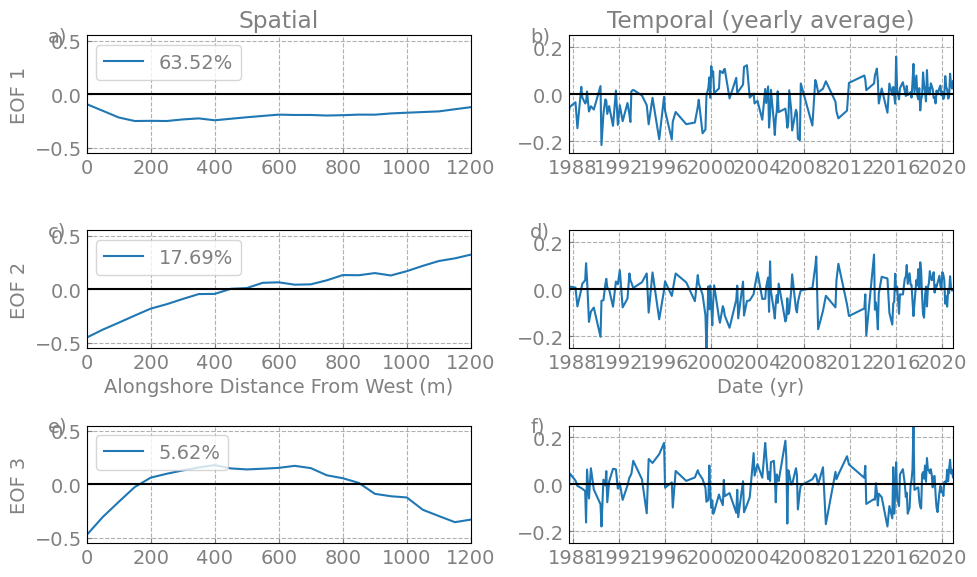

In [115]:
fig, axes = plt.subplots(nrows = k, ncols = 2, figsize = figSize, tight_layout = True)
numTransects = len(e_x)
xtickLabels = df.columns[::4]
xticks = np.arange(0, numTransects)[::4]
yRangeTemp = [-0.25,0.25]

for i in range(k):
    axes[i,0].plot(np.real(e_x[:,i]), label = f'{np.round(pOfVar[i], 2)}%')
    axes[i,0].set_ylabel(f'EOF {i+1}')
    axes[i,0].set_ylim(yRange)
    axes[i,0].legend(loc = labelLoc)
    axes[i,1].plot(df.index, np.real(c_t[:,i]), label = f'{np.round(pOfVar[i], 2)}%')
    axes[i,1].set_ylim(yRangeTemp) 
    for j in range(2):
        axes[i,j].autoscale(enable = True, axis ='x', tight = True)
        axes[i,j].axhline(0, color = 'k')
        axes[i,j].tick_params(direction="in")
        axes[i,j].text(-0.1, 0.95, labelLetters[i][j], transform=axes[i,j].transAxes)
        axes[i,j].grid(ls = '--')
    axes[i,0].set_xticks(xticks)
    axes[i,0].set_xticklabels(xtickLabels)
    

# Spatial and Temporal Titles
for ax, col in zip(axes[0], colTitles):
    ax.set_title(col)
axes[1,0].set_xlabel(xTitle)
axes[1,1].set_xlabel('Date (yr)')

#plt.savefig(plot2Name, dpi = resolution)
plt.show()

In [92]:
c_t1 = np.real(c_t[:,0])
c_t2 = np.real(c_t[:,1])
c_t3 = np.real(c_t[:,2])

df['c_t1'] = c_t1
df['c_t2'] = c_t2
df['c_t3'] = c_t3

xtickMonths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# xtickMonths = ['Mar','Jun','Sep','Dec']
#df.to_csv(dataDir + 'eofs.csv')

In [93]:
df.groupby(df.index.month)[f'c_t{2}'].mean()

dates
1     0.129115
2     0.108306
3     0.126221
4    -0.034251
5    -0.033507
6    -0.117807
7    -0.022735
8    -0.022818
9    -0.041332
10    0.083060
11    0.032958
12    0.129871
Name: c_t2, dtype: float64

In [94]:
df.index.month

Int64Index([ 4,  6,  9, 10, 11, 12,  1,  2,  4,  5,  8, 10, 11, 12,  1,  3,  4,
             5,  6,  7,  8, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            11, 12,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12,  1,  2,  3,  4,
             5,  6,  7,  8,  9, 10, 11, 12],
           dtype='int64', name='dates')

In [95]:
k

3

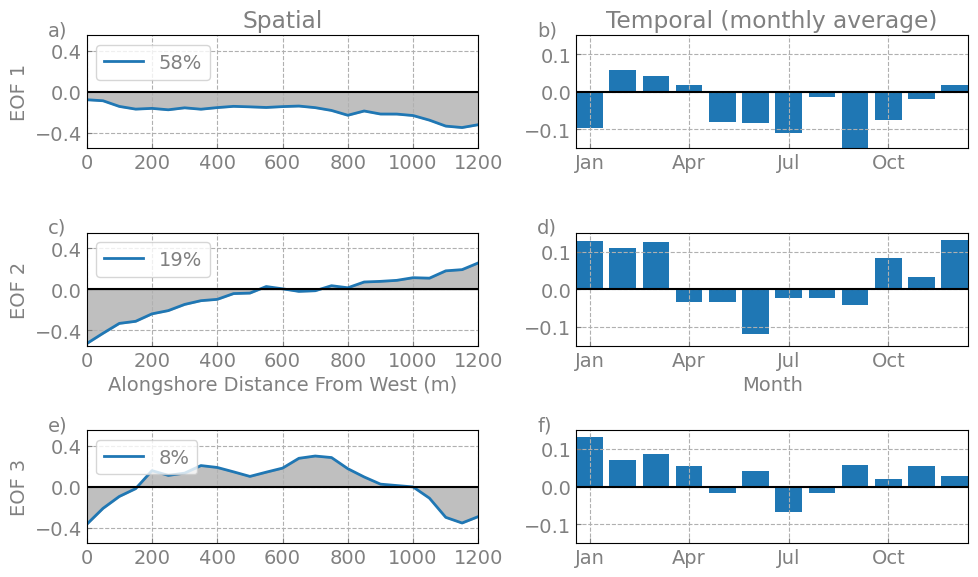

In [101]:
# Plot

fig, axes = plt.subplots(nrows = k, ncols = 2, figsize = figSize, tight_layout = True)
numTransects = len(e_x)
xtickLabels = df.columns[::4]
xticks = np.arange(0, numTransects)[::4]

for i in range(k):
    axes[i,0].plot(np.real(e_x[:,i]), label = f'{int(np.round(pOfVar[i],0))}%', lw = 2)
    axes[i,0].fill_between(np.arange(0, numTransects), np.real(e_x[:,i]), color = 'grey', alpha = 0.5)
    axes[i,0].set_ylabel(f'EOF {i+1}')
    axes[i,0].set_ylim(yRange)
    axes[i,0].set_yticks([-0.4,0,0.4])
    axes[i,0].legend(loc = labelLoc)
    axes[i,1].bar(xtickMonths, df.groupby(df.index.month)[f'c_t{i+1}'].mean())
    axes[i,1].set_ylim(-0.15, 0.15)
    axes[i,1].set_yticks([-0.1,0,0.1])
    for j in range(2):
        axes[i,j].autoscale(enable = True, axis ='x', tight = True)
        axes[i,j].axhline(0, color = 'k')
        axes[i,j].tick_params(direction="in")
        axes[i,j].text(-0.1, 1, labelLetters[i][j], transform=axes[i,j].transAxes)
        axes[i,j].grid(ls = '--')
    axes[i,0].set_xticks(xticks)
    axes[i,0].set_xticklabels(xtickLabels)
    axes[i,1].set_xticks([0,3,6,9])
    

# Spatial and Temporal Titles
colTitles = ['Spatial', 'Temporal (monthly average)']
for ax, col in zip(axes[0], colTitles):
    ax.set_title(col)
axes[1,0].set_xlabel(xTitle)
axes[1,1].set_xlabel('Month')

plt.show()

# plt.savefig(plot2Name, dpi = resolution, bbox_inches = "tight")


In [102]:
len(df)

59

C:\Users\s5245653\AppData\Local\Temp\ipykernel_19272\3275617973.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,1].set_xticklabels(seasonLabels)
C:\Users\s5245653\AppData\Local\Temp\ipykernel_19272\3275617973.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,1].set_xticklabels(seasonLabels)
C:\Users\s5245653\AppData\Local\Temp\ipykernel_19272\3275617973.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,1].set_xticklabels(seasonLabels)


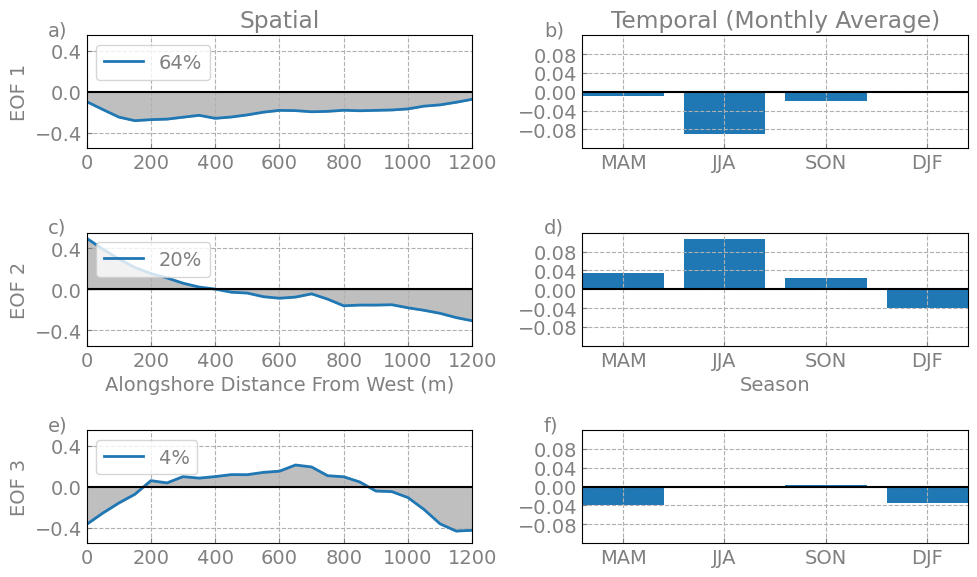

In [67]:
# Seasonal Plot

fig, axes = plt.subplots(nrows = k, ncols = 2, figsize = figSize, tight_layout = True)
numTransects = len(e_x)
xtickLabels = df.columns[::4]
xticks = np.arange(0, numTransects)[::4]
seasonLabels = ['MAM','JJA','SON', 'DJF']

for i in range(k):
    axes[i,0].plot(np.real(e_x[:,i]), label = f'{int(np.round(pOfVar[i],0))}%', lw = 2)
    axes[i,0].fill_between(np.arange(0, numTransects), np.real(e_x[:,i]), color = 'grey', alpha = 0.5)
    axes[i,0].set_ylabel(f'EOF {i+1}')
    axes[i,0].set_ylim(yRange)
    axes[i,0].set_yticks([-0.4,0,0.4])
    axes[i,0].legend(loc = labelLoc)
    axes[i,1].bar(xtickMonths, df.groupby(df.index.month)[f'c_t{i+1}'].mean())
    axes[i,1].set_ylim(-0.12, 0.12)
    axes[i,1].set_yticks([-0.08,-0.04,0,0.04,0.08])
    for j in range(2):
        axes[i,j].autoscale(enable = True, axis ='x', tight = True)
        axes[i,j].axhline(0, color = 'k')
        axes[i,j].tick_params(direction="in")
        axes[i,j].text(-0.1, 1, labelLetters[i][j], transform=axes[i,j].transAxes)
        axes[i,j].grid(ls = '--')
    axes[i,0].set_xticks(xticks)
    axes[i,0].set_xticklabels(xtickLabels)
    axes[i,1].set_xticklabels(seasonLabels)
    

# Spatial and Temporal Titles
for ax, col in zip(axes[0], colTitles):
    ax.set_title(col)
axes[1,0].set_xlabel(xTitle)
axes[1,1].set_xlabel('Season')

plt.show()

# plt.savefig(plot2Name, dpi = resolution, bbox_inches = "tight")

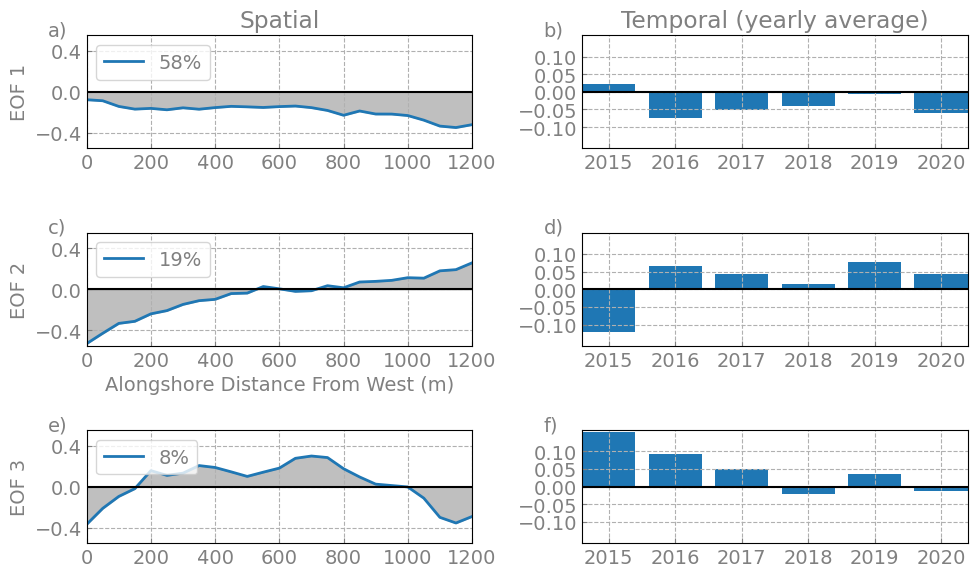

In [103]:
# Yearly Plot

fig, axes = plt.subplots(nrows = k, ncols = 2, figsize = figSize, tight_layout = True)
numTransects = len(e_x)
xtickLabels = df.columns[::4]
xticks = np.arange(0, numTransects)[::4]

for i in range(k):
    axes[i,0].plot(np.real(e_x[:,i]), label = f'{int(np.round(pOfVar[i],0))}%', lw = 2)
    axes[i,0].fill_between(np.arange(0, numTransects), np.real(e_x[:,i]), color = 'grey', alpha = 0.5)
    axes[i,0].set_ylabel(f'EOF {i+1}')
    axes[i,0].set_ylim(yRange)
    axes[i,0].set_yticks([-0.4,0,0.4])
    axes[i,0].legend(loc = labelLoc)
    axes[i,1].bar(df.index.year.unique(), df.groupby(df.index.year)[f'c_t{i+1}'].mean())
    axes[i,1].set_ylim(-0.16, 0.16)
    axes[i,1].set_yticks([-0.10,-0.05,0,0.05,0.10])
    for j in range(2):
        axes[i,j].autoscale(enable = True, axis ='x', tight = True)
        axes[i,j].axhline(0, color = 'k')
        axes[i,j].tick_params(direction="in")
        axes[i,j].text(-0.1, 1, labelLetters[i][j], transform=axes[i,j].transAxes)
        axes[i,j].grid(ls = '--')
    axes[i,0].set_xticks(xticks)
    axes[i,0].set_xticklabels(xtickLabels)
    # axes[i,1].set_xticklabels(seasonLabels)
    

# Spatial and Temporal Titles
colTitles = ['Spatial', 'Temporal (yearly average)']
for ax, col in zip(axes[0], colTitles):
    ax.set_title(col)
axes[1,0].set_xlabel(xTitle)
# axes[1,1].set_xlabel('Season')

plt.show()

# plt.savefig(plot2Name, dpi = resolution, bbox_inches = "tight")

<Axes: >

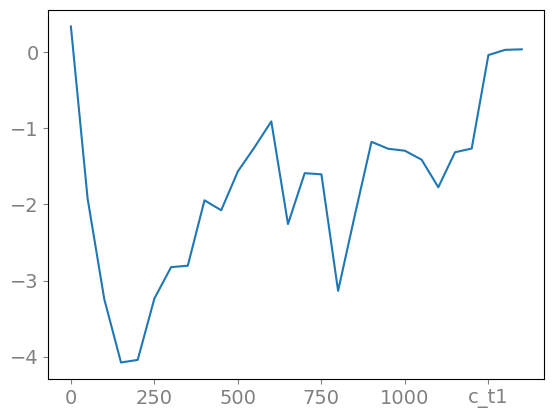

In [105]:
df.mean().plot()

In [53]:
df2 = pd.DataFrame(index = df.index)
c_t1 = np.real(c_t[:,0])
c_t2 = np.real(c_t[:,1])
c_t3 = np.real(c_t[:,2])

df2['c_t1'] = c_t1
df2['c_t2'] = c_t2
df2['c_t3'] = c_t3
#df2.to_csv(dataDir + 'eofs.csv')

In [15]:
df2.head()

,0,50,100,150,200,250,300,350,400,450,...,900,950,1000,1050,1100,1150,1200,c_t1,c_t2,c_t3
dates,,,,,,,,,,,,,,,,,,,,,
1987-09-16 23:31:08+00:00,7.417982,9.272312,13.356582,9.581018,3.433738,2.700332,2.193182,-1.117974,-4.775914,-5.799818,...,0.931853,1.048835,3.313773,-3.325165,-9.972824,-14.800111,-9.494598,-0.004130,-0.054659,0.004174
1987-09-23 23:37:29+00:00,8.514853,17.199469,27.125286,22.670735,26.871896,23.174408,18.577694,15.030062,18.641983,17.605613,...,24.014062,26.388042,21.258094,23.838287,20.979042,15.689518,9.519222,0.129985,-0.015185,-0.041068
1987-10-25 23:38:03+00:00,-3.078514,0.000000,2.776015,8.942182,12.115014,14.388340,9.519966,9.906088,9.749971,5.159858,...,5.441411,0.756025,3.261966,5.045518,1.210751,6.821747,4.316342,0.045653,0.001844,0.040895
1988-04-11 23:34:20+00:00,0.495242,-0.160502,0.329265,5.062602,4.806146,6.505339,9.813689,7.821330,7.384963,6.677046,...,9.354323,3.548776,0.286512,2.730342,6.126721,4.402313,-2.257536,0.028502,0.000964,0.016416
1988-06-21 23:41:02+00:00,16.573319,16.445291,32.287360,33.442557,30.293710,30.379961,25.394161,24.311956,26.862202,21.670857,...,11.184721,10.906603,5.473654,7.108974,12.300082,11.313390,7.155492,0.115340,-0.075976,0.017423


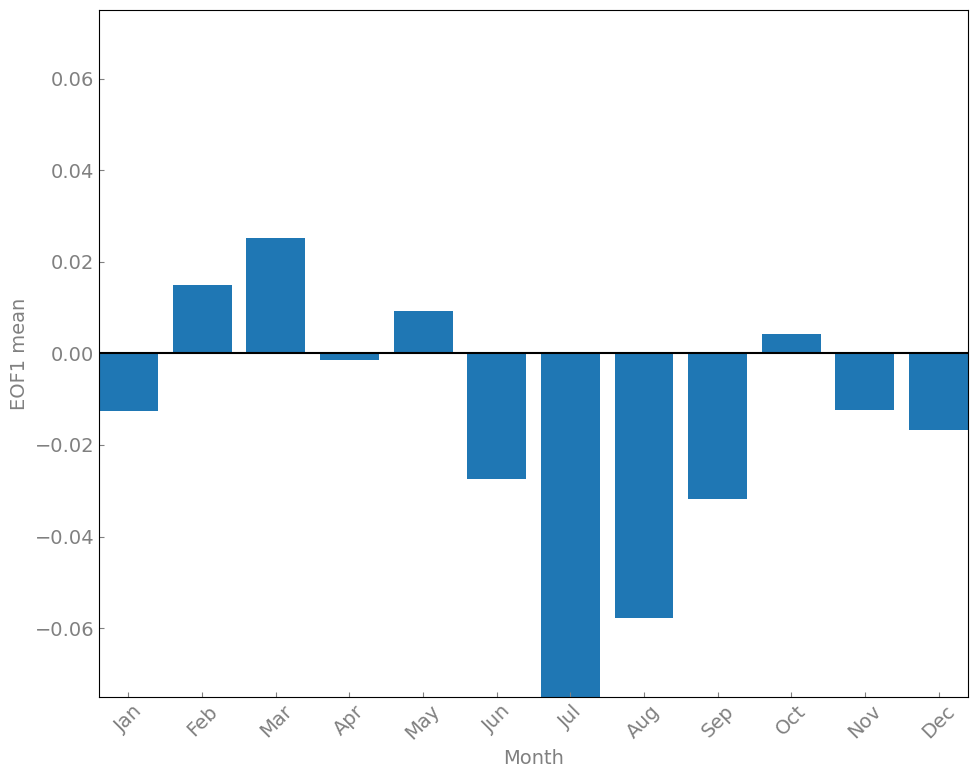

In [55]:
xtickMonths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Monthly averages of "rotation" variability
fig, ax = plt.subplots(figsize = (10,8), tight_layout = True)

ax.bar(xtickMonths,df2.groupby(df2.index.month)['c_t1'].mean())
ax.axhline(0, color = 'k')
ax.tick_params(direction="in")
ax.autoscale(enable = True, axis ='x', tight = True)
plt.xticks(range(0,12), labels = xtickMonths, rotation = 45)
plt.xlabel('Month')
plt.ylabel('EOF1 mean')
plt.ylim(-0.075, 0.075)
# plt.savefig(dataDir + plotDir + 'rotationEOF_.jpg', dpi = resolution)
plt.show()

# The End

## Further Analysis with SAM

In [61]:
SAMloc = 'C:/Users/s5245653/OneDrive - Griffith University/Projects/GrassyWaves/Data/SAMIndex.csv'
SOIloc = 'C:/Users/s5245653/OneDrive - Griffith University/Projects/GrassyWaves/Data/SOI_monthly.txt'


SAMI = pd.read_csv(SAMloc, index_col = 'Unnamed: 0', parse_dates = True)
SAMI.index = pd.to_datetime(SAMI.index, utc = True)
SAMI = SAMI.truncate(before = firstDate, after = lastDate)
SAMI.columns = ['SAMI']


SOI = pd.read_csv(SOIloc, header = None, index_col = 0, parse_dates = True)
SOI.index = pd.to_datetime(SOI.index, format = '%Y%m', utc = True)
SOI = SOI.truncate(before = firstDate, after = lastDate)
SOI.columns = ['SOI']

SAM_SOI = SAMI.join(SOI)
SAM_SOI['Month'] = SAM_SOI.index.month

# Create seasonally-averaged data
Month2Season(SAM_SOI)
dfSAMSOIave = SAM_SOI.resample('3MS').mean()
dfSAMSOIave.head()

C:\Users\s5245653\AppData\Local\Temp\ipykernel_8940\1707722239.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfSAMSOIave = SAM_SOI.resample('3MS').mean()


,SAMI,SOI,Month,Season_Val
1987-09-01 00:00:00+00:00,0.610000,-6.066667,10.0,4.0
1987-12-01 00:00:00+00:00,0.183333,-3.533333,5.0,1.0
1988-03-01 00:00:00+00:00,-0.643333,3.700000,4.0,2.0
1988-06-01 00:00:00+00:00,-1.473333,7.433333,7.0,3.0
1988-09-01 00:00:00+00:00,-2.320000,18.566667,10.0,4.0


In [91]:
df

,0,50,100,150,200,250,300,350,400,450,...,900,950,1000,1050,1100,1150,1200,c_t1,c_t2,c_t3
dates,,,,,,,,,,,,,,,,,,,,,
1987-09-01 00:00:00+00:00,7.966417,13.235891,20.240934,16.125877,15.152817,12.937370,10.385438,6.956044,6.933035,5.902898,...,12.472957,13.718439,12.285933,10.256561,5.503109,0.444703,0.012312,-0.078487,-0.029870,-0.032206
1987-10-01 00:00:00+00:00,-3.078514,0.000000,2.776015,8.942182,12.115014,14.388340,9.519966,9.906088,9.749971,5.159858,...,5.441411,0.756025,3.261966,5.045518,1.210751,6.821747,4.316342,-0.055137,0.011406,0.047009
1988-04-01 00:00:00+00:00,0.495242,-0.160502,0.329265,5.062602,4.806146,6.505339,9.813689,7.821330,7.384963,6.677046,...,9.354323,3.548776,0.286512,2.730342,6.126721,4.402313,-2.257536,-0.034565,0.006845,0.016094
1988-06-01 00:00:00+00:00,16.573319,16.445291,32.287360,33.442557,30.293710,30.379961,25.394161,24.311956,26.862202,21.670857,...,11.184721,10.906603,5.473654,7.108974,12.300082,11.313390,7.155492,-0.144990,-0.073082,-0.006396
1988-10-01 00:00:00+00:00,-8.223803,0.707300,-6.153669,2.070906,-4.887449,-3.566849,-4.682333,-2.962405,7.977137,-3.841543,...,-1.937516,3.182389,-0.547250,-2.780050,-2.767379,0.595101,-0.085976,0.030823,-0.000757,-0.015580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 00:00:00+00:00,3.756266,-9.792985,5.062338,0.930565,5.840097,3.119905,3.644749,3.793464,3.166802,3.786811,...,0.022800,-1.057768,-3.849035,-4.581209,-4.173424,-5.778049,-1.804925,-0.012786,-0.016836,0.066849
2020-09-01 00:00:00+00:00,-27.671800,-25.745188,-12.313324,-9.734480,-9.984420,-18.516084,-14.490019,-21.058042,-19.959141,-10.659644,...,-1.639256,-4.536610,-12.037537,-11.966314,-12.832524,-8.730814,-9.131890,0.086769,0.055189,0.104616
2020-10-01 00:00:00+00:00,-0.230633,-10.862183,-9.068924,-11.974880,-6.273190,-8.117855,-5.460668,-2.616350,-3.163346,-0.839469,...,-4.078218,-3.934211,-4.793720,-7.399180,-4.207491,-9.807678,-5.825623,0.040119,0.005741,0.046527


In [108]:
df_ = df.copy(deep = True)
df_['Month'] = df_.index.month
Month2Season(df_)
df_ = df_.reset_index()
# Monthly average of SAMSOI values
dfAll = pd.merge(
    df_,
    SAM_SOI[['SAMI', 'SOI']],
    left_on=[df_.Month, df_.dates.dt.year],
    right_on=[SAM_SOI.Month, SAM_SOI.index.year],
)
dfAll.index = dfAll['dates']
dfAll = dfAll.drop(['key_0', 'key_1', 'dates','c_t1','c_t2','c_t3'], axis = 1)
# Seasonal average of SAMSOI values
dfAllave = pd.merge(
    df_,
    dfSAMSOIave[['SAMI', 'SOI']],
    left_on=[df_.Season_Val, df_.dates.dt.year],
    right_on=[dfSAMSOIave.Season_Val, dfSAMSOIave.index.year],
)
dfAllave.index = dfAllave['dates']
dfAllave = dfAllave.drop(['key_0', 'key_1', 'dates'], axis = 1)

#dfAllave.to_csv(dataDir + 'ShorelineDataSeasonalClimate.csv')
dfMerged = dfAll.copy(deep = True)
dfMerged = dfMerged.drop(['SAMI', 'SOI', 'Month', 'Season', 'Season_Val'], axis = 1)

dfPos = dfAll[dfAll['SAMI']>=0]
dfNeg = dfAll[dfAll['SAMI']<0]

In [107]:
dfNeg

,0,50,100,150,200,250,300,350,400,450,...,750,800,850,900,950,1000,1050,1100,1150,1200
dates,,,,,,,,,,,,,,,,,,,,,
1987-09-01 00:00:00+00:00,7.966417,13.235891,20.240934,16.125877,15.152817,12.937370,10.385438,6.956044,6.933035,5.902898,...,7.341703,12.279896,13.483651,12.472957,13.718439,12.285933,10.256561,5.503109,0.444703,0.012312
1988-06-01 00:00:00+00:00,16.573319,16.445291,32.287360,33.442557,30.293710,30.379961,25.394161,24.311956,26.862202,21.670857,...,7.918617,13.298949,18.733788,11.184721,10.906603,5.473654,7.108974,12.300082,11.313390,7.155492
1988-10-01 00:00:00+00:00,-8.223803,0.707300,-6.153669,2.070906,-4.887449,-3.566849,-4.682333,-2.962405,7.977137,-3.841543,...,-8.770224,-12.671801,-11.976645,-1.937516,3.182389,-0.547250,-2.780050,-2.767379,0.595101,-0.085976
1989-08-01 00:00:00+00:00,6.700391,6.998816,12.732965,23.103989,19.667579,25.090379,14.598206,10.504328,10.608268,10.663975,...,1.912340,-4.680674,7.066858,10.352053,3.155017,2.269156,-10.548609,-11.411471,-7.656390,-6.046780
1990-06-01 00:00:00+00:00,24.358611,26.400965,22.588750,23.161655,4.658913,4.888052,6.206440,-1.556252,-4.723832,-7.706513,...,-17.614816,-12.162549,-10.562230,-4.823005,-5.818939,-6.501826,-20.390447,-30.714914,-14.218309,-9.694140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01 00:00:00+00:00,1.786841,-4.389781,-7.349909,-8.605997,-2.810371,1.431219,6.310217,8.646304,7.654177,1.400110,...,3.321308,3.346158,3.051369,4.144143,5.586081,8.280090,8.258214,12.137278,12.000943,11.103148
2020-04-01 00:00:00+00:00,2.486379,-1.460279,-3.685353,-9.066299,-7.824834,-7.742261,-7.568215,-9.526440,-8.072239,-6.772940,...,-19.823678,-21.961381,-11.546536,-9.981013,-10.619557,-12.340749,-10.982923,-10.590439,-13.436014,-14.743126
2020-07-01 00:00:00+00:00,2.970620,-1.107150,2.993982,3.486282,2.237007,1.346716,1.182439,4.037086,3.190534,1.674976,...,6.248101,5.186033,2.829957,1.568972,4.832243,4.282630,1.360221,1.436425,1.487607,-5.899273


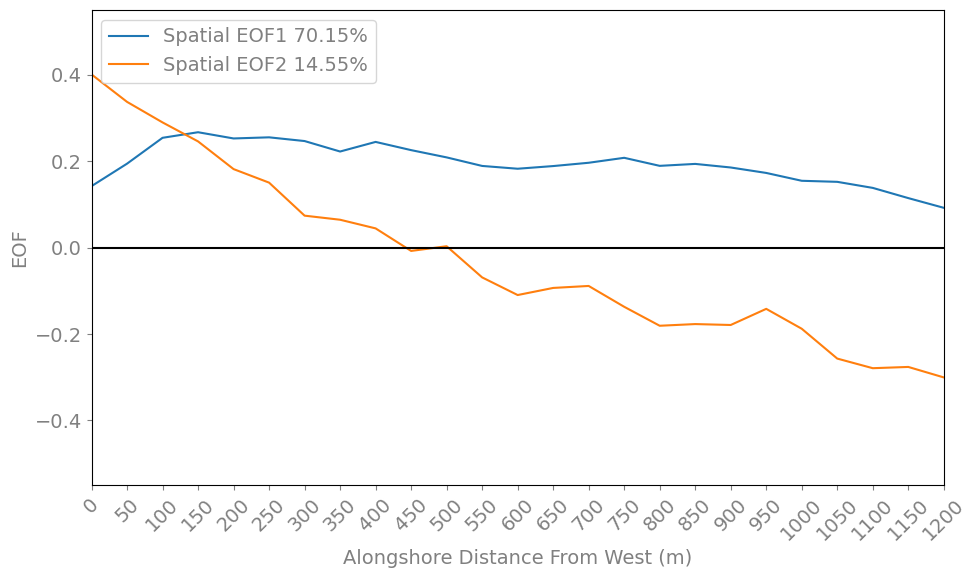

In [106]:
dfNeg = dfNeg.drop(columns = ['SAMI', 'SOI', 'Month', 'Season', 'Season_Val'])
dfNeg = dfNeg.dropna()

# Create matrix of the data
yNeg = dfNeg.to_numpy()
yNeg_t = yNeg.transpose()

# Create a spatial covariance-like matrix
temp = 1 / yNeg.size
aNeg = temp * np.matmul(yNeg_t, yNeg) # a measure of the spatial covariance
bNeg = temp * np.matmul(yNeg, yNeg_t) # a measure of the temporal covariance


# Compute eigenvalues and eigenvectors from matrices
eigenValuesNeg, eigenVectorsNeg = np.linalg.eig(aNeg)
eigenValuesBNeg, cNeg = np.linalg.eig(bNeg)

# Returns eigenValues in order from largest to smallest, with eigenVectors returned as corresponding columns
idxNeg = eigenValuesNeg.argsort()[::-1]
eigenValuesNeg = eigenValuesNeg[idxNeg]
e_xNeg = eigenVectorsNeg[:,idxNeg]

idxNeg = eigenValuesBNeg.argsort()[::-1]
eigenValuesBNeg = eigenValuesBNeg[idxNeg] # first nx eigenvaluesB should equal eigenvalues from A
c_tNeg = cNeg[:,idxNeg]

# Calculate percent of variance represented by the eigenfunctions
pOfVarNeg = np.divide(100 * np.real(eigenValuesNeg), np.sum(np.real(eigenValuesNeg)))
kNeg = sum(map(lambda x : x > minVarianceOfInterest, pOfVarNeg)) # number of eigenfunctions (vectors) to plot
# Ensure at least 2 eigenfunctions are plotted
if kNeg == 1:
    kNeg = 2
    
# Weights
wNeg = [np.sqrt(eigenValuesNeg[i]*yNeg.size) for i in range(kNeg)]


# Plot Spatial variability

# Plot Variables
numTransects = len(e_xNeg)
xtickLabels = dfNeg.columns
xticks = np.arange(0, numTransects)

# Plotting
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)

for i in range(kNeg):
    if i == 0:
        ax.plot(np.multiply(1,np.real(e_xNeg[:,i])), label = f'Spatial EOF{i+1} {np.round(pOfVarNeg[i], 2)}%')
    else:
        ax.plot(np.real(e_xNeg[:,i]), label = f'Spatial EOF{i+1} {np.round(pOfVarNeg[i], 2)}%')
ax.legend(loc = labelLoc)
ax.axhline(0, color = 'k')
#ax.grid()

plt.xticks(xticks, labels = xtickLabels, rotation = 45)
plt.xlabel(xTitle)
plt.ylabel(yTitle)
plt.ylim(yRange)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

#plotName = '_Neg.jpg'
#plt.savefig(plotName, dpi = resolution)

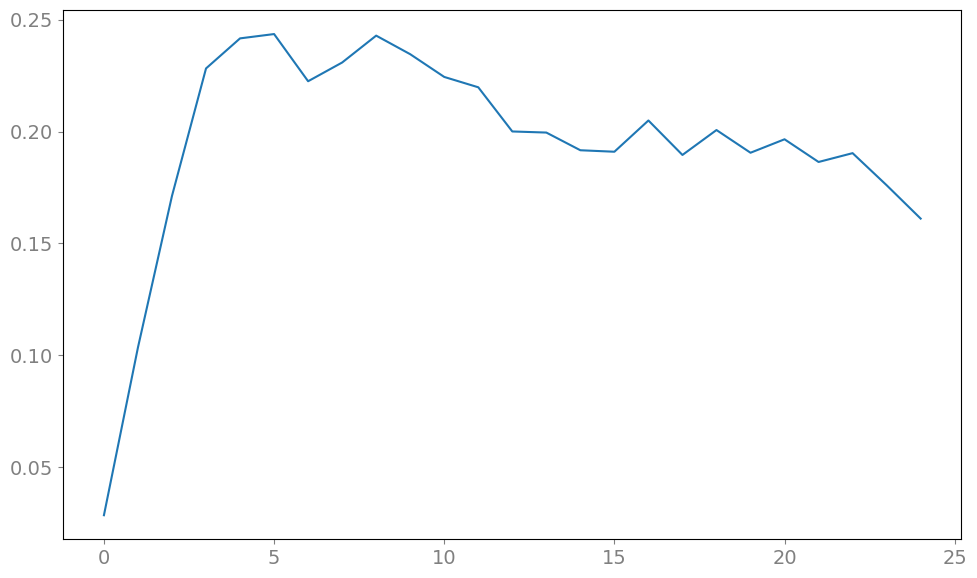

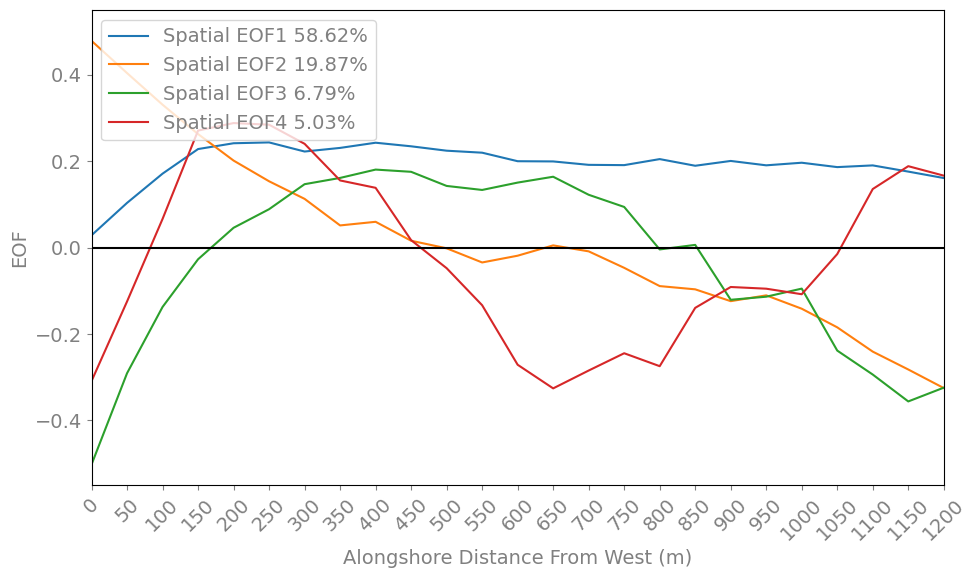

In [105]:
dfPos = dfPos.drop(columns = ['SAMI', 'SOI', 'Month', 'Season', 'Season_Val'])
dfPos = dfPos.dropna()

# Create matrix of the data
yPos = dfPos.to_numpy()
yPos_t = yPos.transpose()

# Create a spatial covariance-like matrix
temp = 1 / yPos.size
aPos = temp * np.matmul(yPos_t, yPos) # a measure of the spatial covariance
bPos = temp * np.matmul(yPos, yPos_t) # a measure of the temporal covariance


# Compute eigenvalues and eigenvectors from matrices
eigenValuesPos, eigenVectorsPos = np.linalg.eig(aPos)
eigenValuesBPos, cPos = np.linalg.eig(bPos)

# Returns eigenValues in order from largest to smallest, with eigenVectors returned as corresponding columns
idxPos = eigenValuesPos.argsort()[::-1]
eigenValuesPos = eigenValuesPos[idxPos]
e_xPos = eigenVectorsPos[:,idxPos]

idxPos = eigenValuesBPos.argsort()[::-1]
eigenValuesBPos = eigenValuesBPos[idxPos] # first nx eigenvaluesB should equal eigenvalues from A
c_tPos = cPos[:,idxPos]

# Calculate percent of variance represented by the eigenfunctions
pOfVarPos = np.divide(100 * np.real(eigenValuesPos), np.sum(np.real(eigenValuesPos)))
kPos = sum(map(lambda x : x > minVarianceOfInterest, pOfVarPos)) # number of eigenfunctions (vectors) to plot
# Ensure at least 2 eigenfunctions are plotted
if kPos == 1:
    kPos = 2
    
# Weights
wPos = [np.sqrt(eigenValuesPos[i]*yPos.size) for i in range(kPos)]


# Plot Spatial variability

# Plot Variables
numTransects = len(e_xPos)
xtickLabels = dfPos.columns
xticks = np.arange(0, numTransects)

# Plotting
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)

for i in range(kPos):
    if i == 0:
        ax.plot(np.multiply(1,np.real(e_xPos[:,i])), label = f'Spatial EOF{i+1} {np.round(pOfVarPos[i], 2)}%')
    else:
        ax.plot(np.real(e_xPos[:,i]), label = f'Spatial EOF{i+1} {np.round(pOfVarPos[i], 2)}%')
ax.legend(loc = labelLoc)
ax.axhline(0, color = 'k')
#ax.grid()

plt.xticks(xticks, labels = xtickLabels, rotation = 45)
plt.xlabel(xTitle)
plt.ylabel(yTitle)
plt.ylim(yRange)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

#plotName = '_pos.jpg'
#plt.savefig(plotName, dpi = resolution)

In [133]:
SAMposyears = dfSAMSOIave[(dfSAMSOIave['Season_Val'] == 3.0) & (dfSAMSOIave['SAMI'] >= 0)].index.year
SAMnegyears = dfSAMSOIave[(dfSAMSOIave['Season_Val'] == 3.0) & (dfSAMSOIave['SAMI'] < 0)].index.year

SAMpossummeryears = dfSAMSOIave[((dfSAMSOIave['Season_Val'] == 1.0) & (dfSAMSOIave['SAMI'] >= 0))].index.year
SAMposyears = [i for i in SAMpossummeryears if i in SAMnegyears]

# minNumVals = 5
# valsEachPosYear = [len(j) for i,j in dfposSAM.groupby(dfposSAM.index.year)]
# valsEachNegYear = [len(j) for i,j in dfnegSAM.groupby(dfnegSAM.index.year)]

# idxsPos = []
# idxsNeg = []
# for i in range(len(valsEachPosYear)):
#     if valsEachPosYear[i] < minNumVals :
#         idxsPos.append(i)
# for i in range(len(valsEachNegYear)):
#     if valsEachNegYear[i] < minNumVals:
#         idxsNeg.append(i)

# SAMposyears = SAMposyears.delete(idxsPos)
# SAMnegyears = SAMnegyears.delete(idxsNeg)

dfposSAM = dfMerged[dfMerged.index.year.isin(SAMposyears)]
#dfposSAM.to_csv(dataDir + 'SAM_pos.csv')
dfnegSAM = dfMerged[dfMerged.index.year.isin(SAMnegyears)]
#dfnegSAM.to_csv(dataDir + 'SAM_neg.csv')
# dfposSAM

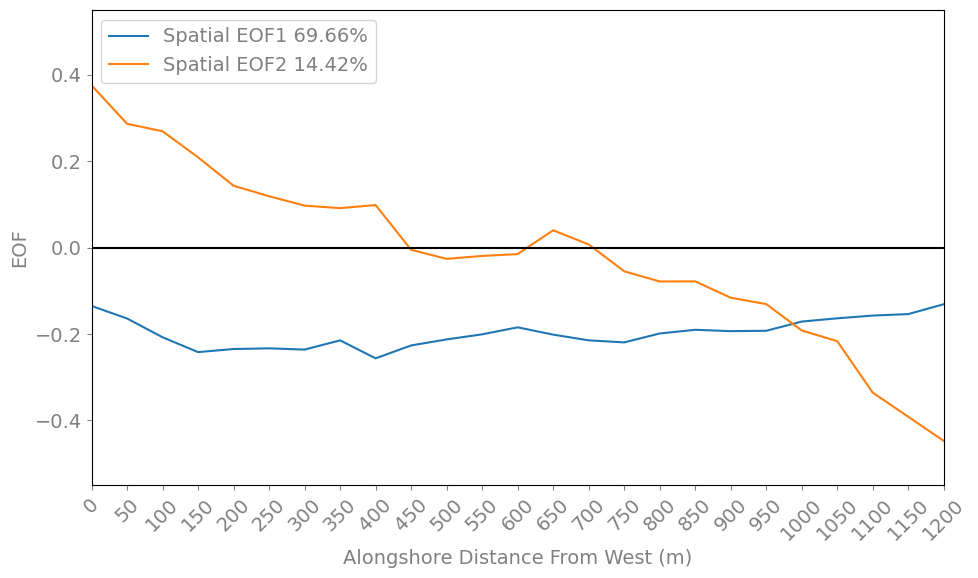

In [134]:
dfPos = dfposSAM.dropna()

# Create matrix of the data
yPos = dfPos.to_numpy()
yPos_t = yPos.transpose()

# Create a spatial covariance-like matrix
temp = 1 / yPos.size
aPos = temp * np.matmul(yPos_t, yPos) # a measure of the spatial covariance
bPos = temp * np.matmul(yPos, yPos_t) # a measure of the temporal covariance


# Compute eigenvalues and eigenvectors from matrices
eigenValuesPos, eigenVectorsPos = np.linalg.eig(aPos)
eigenValuesBPos, cPos = np.linalg.eig(bPos)

# Returns eigenValues in order from largest to smallest, with eigenVectors returned as corresponding columns
idxPos = eigenValuesPos.argsort()[::-1]
eigenValuesPos = eigenValuesPos[idxPos]
e_xPos = eigenVectorsPos[:,idxPos]

idxPos = eigenValuesBPos.argsort()[::-1]
eigenValuesBPos = eigenValuesBPos[idxPos] # first nx eigenvaluesB should equal eigenvalues from A
c_tPos = cPos[:,idxPos]

# Calculate percent of variance represented by the eigenfunctions
pOfVarPos = np.divide(100 * np.real(eigenValuesPos), np.sum(np.real(eigenValuesPos)))
kPos = sum(map(lambda x : x > minVarianceOfInterest, pOfVarPos)) # number of eigenfunctions (vectors) to plot
# Ensure at least 2 eigenfunctions are plotted
if kPos == 1:
    kPos = 2
    
# Weights
wPos = [np.sqrt(eigenValuesPos[i]*yPos.size) for i in range(kPos)]


# Plot Spatial variability

# Plot Variables
numTransects = len(e_xPos)
xtickLabels = dfPos.columns
xticks = np.arange(0, numTransects)

# Plotting
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)

for i in range(kPos):
    if i == 0:
        ax.plot(np.multiply(1,np.real(e_xPos[:,i])), label = f'Spatial EOF{i+1} {np.round(pOfVarPos[i], 2)}%')
    else:
        ax.plot(np.real(e_xPos[:,i]), label = f'Spatial EOF{i+1} {np.round(pOfVarPos[i], 2)}%')
ax.legend(loc = labelLoc)
ax.axhline(0, color = 'k')
#ax.grid()

plt.xticks(xticks, labels = xtickLabels, rotation = 45)
plt.xlabel(xTitle)
plt.ylabel(yTitle)
plt.ylim(yRange)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

#plotName = '_pos.jpg'
#plt.savefig(plotName, dpi = resolution)

In [64]:
a = df_[df_['Season'] == 'Winter'].mean().drop(['Month', 'Season_Val'])
a

C:\Users\s5245653\AppData\Local\Temp\ipykernel_8940\4102312468.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  a = df_[df_['Season'] == 'Winter'].mean().drop(['Month', 'Season_Val'])
C:\Users\s5245653\AppData\Local\Temp\ipykernel_8940\4102312468.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  a = df_[df_['Season'] == 'Winter'].mean().drop(['Month', 'Season_Val'])


0       15.243989
50      14.841503
100     15.705370
150     13.574660
200     12.574649
250     12.045569
300     11.156893
350      9.143929
400     10.280811
450      8.072796
500      7.159975
550      5.146998
600      5.494169
650      5.864267
700      6.387869
750      5.490551
800      1.772919
850      2.775147
900      3.195268
950      3.756474
1000     3.269808
1050     0.244803
1100    -1.665059
1150    -1.877507
1200    -5.188959
c_t1    -0.055529
c_t2    -0.076939
c_t3     0.000945
dtype: float64

C:\Users\s5245653\AppData\Local\Temp\ipykernel_8940\3576545520.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.scatter(df.columns, df_[df_['Season'] == 'Winter'].median().drop(['Month', 'Season_Val']),
C:\Users\s5245653\AppData\Local\Temp\ipykernel_8940\3576545520.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax.scatter(df.columns, df_[df_['Season'] == 'Winter'].median().drop(['Month', 'Season_Val']),
C:\Users\s5245653\AppData\Local\Temp\ipykernel_8940\3576545520.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.scatter(df.columns, df_[df_['S

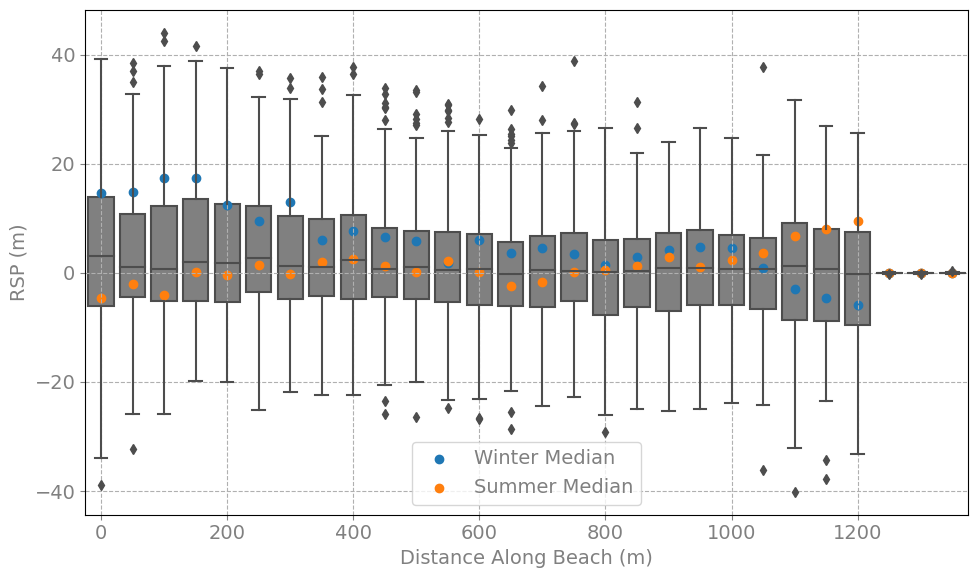

In [65]:
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)
ax = sns.boxplot(data=df[df.columns], color = 'grey')
ax.scatter(df.columns, df_[df_['Season'] == 'Winter'].median().drop(['Month', 'Season_Val']), 
           color = 'C0', label = 'Winter Median')
ax.scatter(df.columns, df_[df_['Season'] == 'Summer'].median().drop(['Month', 'Season_Val']), 
           color = 'C1', label = 'Summer Median')
ax.set_xticks(np.arange(0, 25, 4))
ax.set_xticklabels(np.arange(0, 1250, 200))
plt.xlabel('Distance Along Beach (m)')
plt.ylabel('RSP (m)')
plt.legend()
plt.grid(ls = '--')
#plt.savefig(plotDir + 'test1.jpg', dpi = resolution)
plt.show()

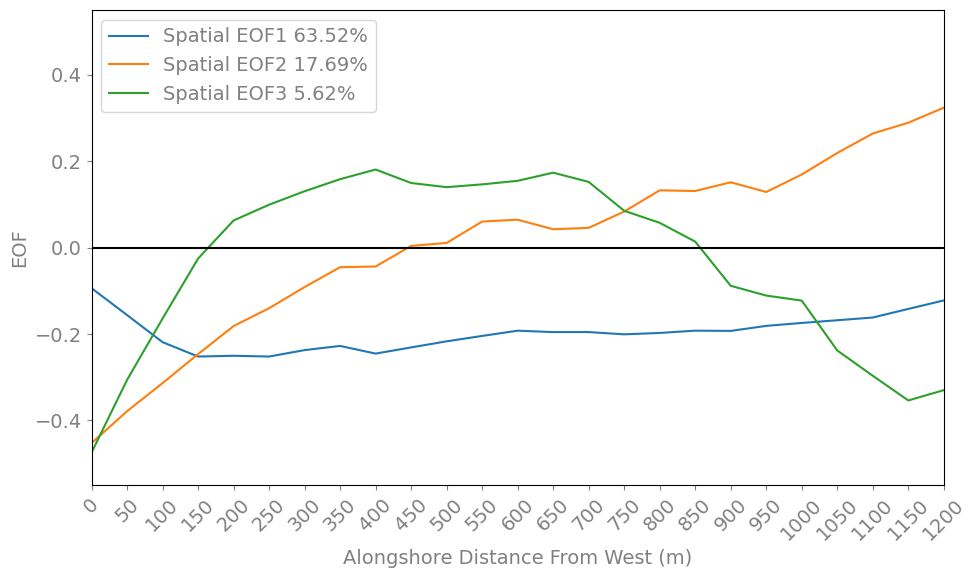

In [68]:
df4 = dfMerged.copy(deep = True)
df4 = df4.drop(columns = ['c_t1','c_t2','c_t3'])
df4 = df4.dropna()

# Create matrix of the data
y4 = df4.to_numpy()
y4_t = y4.transpose()

# Create a spatial covariance-like matrix
temp = 1 / y4.size
a4 = temp * np.matmul(y4_t, y4) # a measure of the spatial covariance
b4 = temp * np.matmul(y4, y4_t) # a measure of the temporal covariance


# Compute eigenvalues and eigenvectors from matrices
eigenValues4, eigenVectors4 = np.linalg.eig(a4)
eigenValuesB4, c4 = np.linalg.eig(b4)

# Returns eigenValues in order from largest to smallest, with eigenVectors returned as corresponding columns
idx4 = eigenValues4.argsort()[::-1]
eigenValues4 = eigenValues4[idx4]
e_x4 = eigenVectors4[:,idx4]

idx4 = eigenValuesB4.argsort()[::-1]
eigenValuesB4 = eigenValuesB4[idx4] # first nx eigenvaluesB should equal eigenvalues from A
c_t4 = c4[:,idx4]

# Calculate percent of variance represented by the eigenfunctions
pOfVar4 = np.divide(100 * np.real(eigenValues4), np.sum(np.real(eigenValues4)))
k4 = sum(map(lambda x : x > minVarianceOfInterest, pOfVar4)) # number of eigenfunctions (vectors) to plot
# Ensure at least 2 eigenfunctions are plotted
if k4 == 1:
    k4 = 2
    
# Weights
w4 = [np.sqrt(eigenValues4[i]*y4.size) for i in range(k4)]


# Plot Spatial variability

# Plot Variables
numTransects = len(e_x4)
xtickLabels = df4.columns
xticks = np.arange(0, numTransects)

# Plotting
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)

for i in range(k4):
    if i == 0:
        ax.plot(np.multiply(1,np.real(e_x4[:,i])), label = f'Spatial EOF{i+1} {np.round(pOfVar4[i], 2)}%')
    else:
        ax.plot(np.real(e_x4[:,i]), label = f'Spatial EOF{i+1} {np.round(pOfVar4[i], 2)}%')
ax.legend(loc = labelLoc)
ax.axhline(0, color = 'k')
#ax.grid()

plt.xticks(xticks, labels = xtickLabels, rotation = 45)
plt.xlabel(xTitle)
plt.ylabel(yTitle)
plt.ylim(yRange)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

#plotName = '_pos.jpg'
#plt.savefig(plotName, dpi = resolution)

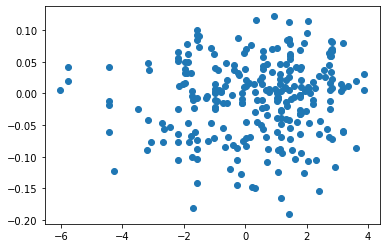

In [35]:
fig, ax = plt.subplots()
ax.scatter(merged_df['SAMI'], merged_df['c_t2'])

In [ ]:
# Ranges of shoreline positions from the first EOF related to each transect location
# e.g. shoreline variability resulting from the first EOF has a range of 19 m at the western profile 
ranges = []
means = []
for j in range(k):
    temp = [np.ptp((e_x[:,j] * w[j])[i] * c_t1) for i in range(y.shape[1])]
    temp2 = [np.mean((e_x[:,j] * w[j])[i] * c_t1) for i in range(y.shape[1])]
    ranges.append(temp)
    means.append(temp2)

In [ ]:
pOfVar[0] + pOfVar[1]

#### Plotting Comparing Each End of the Beach

[]

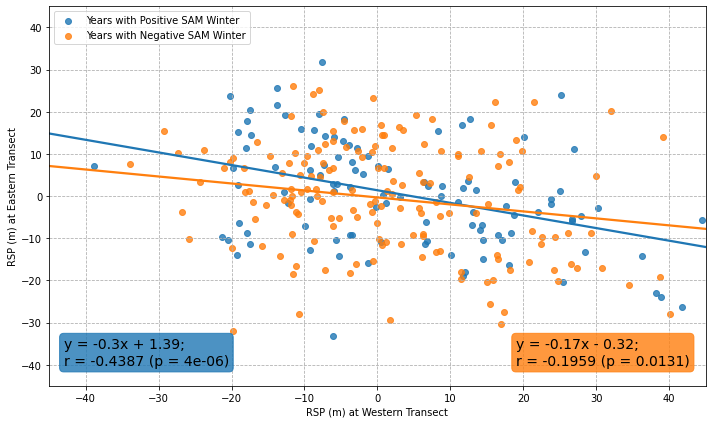

In [295]:
firstTrans = '0'
lastTrans = '1200'
limits = [-45, 45]

pearsonValsPos = sst.pearsonr(dfposSAM.dropna()[firstTrans], dfposSAM.dropna()[lastTrans])
pearsonValsNeg = sst.pearsonr(dfnegSAM.dropna()[firstTrans], dfnegSAM.dropna()[lastTrans])

fig, ax = plt.subplots(figsize = figSize, tight_layout = True)
plt.ylim(limits)
plt.xlim(limits)

#a = sns.regplot(x = dfAllave[firstTrans], y = dfAllave[lastTrans], color = 'C0')
POS = sns.regplot(x = dfposSAM[firstTrans], y = dfposSAM[lastTrans], truncate = False,
                ci = None, color = 'C0', label = 'Years with Positive SAM Winter')
xs = POS.get_lines()[0].get_xdata()
ys = POS.get_lines()[0].get_ydata()
A = np.vstack([xs, np.ones(len(xs))]).T
m, c = np.round(np.linalg.lstsq(A, ys, rcond = None)[0], 2)
props = dict(boxstyle='round', alpha=0.8, color=sns.color_palette()[0])
POS.text(-43, -40, f'y = {m}x + {c}; \nr = {np.round(pearsonValsPos[0],4)} (p = {np.round(pearsonValsPos[1],6)})', 
         color = 'k', fontsize = 14, bbox = props)

NEG = sns.regplot(x = dfnegSAM[firstTrans], y = dfnegSAM[lastTrans], truncate = False,
                ci = None, color = 'C1', label = 'Years with Negative SAM Winter')
xs = NEG.get_lines()[1].get_xdata()
ys = NEG.get_lines()[1].get_ydata()
A = np.vstack([xs, np.ones(len(xs))]).T
m, c = np.round(np.linalg.lstsq(A, ys, rcond = None)[0], 2)
props = dict(boxstyle='round', alpha=0.8, color=sns.color_palette()[1])
NEG.text(19, -40, f'y = {m}x - {np.abs(c)}; \nr = {np.round(pearsonValsNeg[0],4)} (p = {np.round(pearsonValsNeg[1],4)})',
         color = 'k', fontsize=14, bbox=props)

plt.xlabel('RSP (m) at Western Transect')
plt.ylabel('RSP (m) at Eastern Transect')
plt.grid(ls = '--')
plt.legend(loc = labelLoc)


#plt.savefig(plotDir + 'test.jpg', dpi = resolution)
plt.plot()